In [1]:
!pip install mpld3

Defaulting to user installation because normal site-packages is not writeable


ModuleNotFoundError: No module named 'ntlk'

In [6]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS

In [13]:
# Let's use the same complaint dataset we use for classification
Data = pd.read_csv('consumercomplaints.csv', encoding='latin-1',low_memory=False)
Data.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [14]:
Data.shape

(555957, 18)

In [15]:
#selecting required cols and rows

Data = Data[['consumer_complaint_narrative']]
Data = Data[pd.notnull(Data['consumer_complaint_narrative'])]

# Let's do the clustering for just 200 docs. It is easier to interpret
Data_sample = Data.sample(200)

In [16]:
Data_sample.head()

,consumer_complaint_narrative
515527,"On XXXX XXXX, 2016 I appeared at an alleged cr..."
254412,I sent my XX/XX/<YYYY> monthly mortgage paymen...
508555,My husband was unemployed for two and a half y...
210796,The reward from my Bank of America XXXX XXXX X...
290488,"a collection appeared on my credit report, thi..."


In [17]:
# Remove unwanted symbols
Data_sample['consumer_complaint_narrative'] = Data_sample['consumer_complaint_narrative'].str.replace('XXXX','')

In [18]:
# Convert dataframe to list
complaints = Data_sample['consumer_complaint_narrative'].to_list()


# Create the rank of documents - we will use it later
ranks = []
for i in range(1, len(complaints)+1):
    ranks.append(i)
    

# stop words
stopwords = nltk.corpus.stopwords.words('english')

#load 'stemmer'
stemmer = SnowballStemmer('english')


In [19]:
# FUnctions for sentence tokenizer, to remove numeric tokens and raw #punctuation
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems 

In [20]:
# if you want to have tokens only (without applying stemmer), use this method
def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens


In [21]:
#tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000, min_df=0.2, stop_words='english', use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

#fit the vectorizer to data
tfidf_matrix = tfidf_vectorizer.fit_transform(complaints)
terms = tfidf_vectorizer.get_feature_names_out()
print(tfidf_matrix.shape)

C:\Programs\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


(200, 32)


In [22]:
print(terms)

['account' 'ani' 'ask' 'bank' 'becaus' 'card' 'compani' 'contact' 'credit'
 'credit report' 'day' 'debt' 'did' 'inform' 'letter' 'loan' 'make'
 'month' "n't" 'number' 'paid' 'pay' 'payment' 'receiv' 'report' 'request'
 'servic' 'sinc' 'state' 'time' 'told' 'year']


In [11]:
# Cluster using k-means

In [23]:
# Import Kmeans
from sklearn.cluster import KMeans

# Define number of 
num_clusters = 6

#Running clustering algorithm
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

# final_clusters
clusters = km.labels_.tolist()

complaints_data = {'rank': ranks, 'complaints': complaints, 'cluster': clusters}
complaints_data.items()


dict_items([('rank', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200]), ('complaints', ['On  , 2016 I appeared at an alleged creditor foreclosure hearing ca

In [24]:
frame = pd.DataFrame(complaints_data, index=[clusters], columns=['rank','cluster'])
frame.head()

,rank,cluster
2,1,2
4,2,4
0,3,0
3,4,3
1,5,1


In [26]:
# valuecount for each clusters
frame['cluster'].value_counts()

0    62
1    51
2    23
4    23
3    22
5    19
Name: cluster, dtype: int64

In [12]:
# Identify cluster behavior
# identify top five words that are nearest to the cluster centroid

In [31]:
totalvocab_stemmed = []
totalvocab_tokenized = []

for i in complaints:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
    
vocab_frame = pd.DataFrame({'words':totalvocab_tokenized}, index=totalvocab_stemmed)
vocab_frame.head()

,words
on,on
i,i
appear,appeared
at,at
an,an


In [28]:
# Difference between append and extend
l1 = [1,2,3,4]
l2 = [6,7]

# l1.append(l2) #==> [1, 2, 3, 4, [6, 7]]  -> size is 5
l1.extend(l2) #==> [1, 2, 3, 4, 6, 7] -> size is 6
print(l1)

[1, 2, 3, 4, 6, 7]


In [ ]:
# if you have target variable, you go for classification
# If not target variable, you need to go for clustering

In [32]:
# sort the cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:,::-1]

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i,:6]:
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8','ignore'),end=',')
    print()

Cluster 0 words: b"n't", b'card', b'timely', b'receive', b'pay', b'years',
Cluster 1 words: b'reporting', b'credit', b'credit', b'account', b'inform', b'company',
Cluster 2 words: b'debt', b'letters', b'paid', b'account', b'credit', b'receive',
Cluster 3 words: b'banking', b'account', b'requesting', b'payment', b"n't", b'because',
Cluster 4 words: b'loan', b'payment', b'monthly', b'pay', b'servicer', b'asked',
Cluster 5 words: b'payment', b'told', b'make', b'account', b'day', b'monthly',


In [33]:
# Similarity

similarity_distance = 1 - cosine_similarity(tfidf_matrix)

#Convert two components as we're plotting points in a two-dimensional plane
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
pos = mds.fit_transform(similarity_distance)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

#Setup colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',5: '#D2691E'}

#setup cluster names using a dict
cluster_names = {0: 'property, based, assist', 
                 1: 'business, card', 
                 2: 'authorized, approved, believe', 
                 3: 'agreement, application,business', 
                 4: 'closed, applied, additional',
                 5: 'applied, card'}

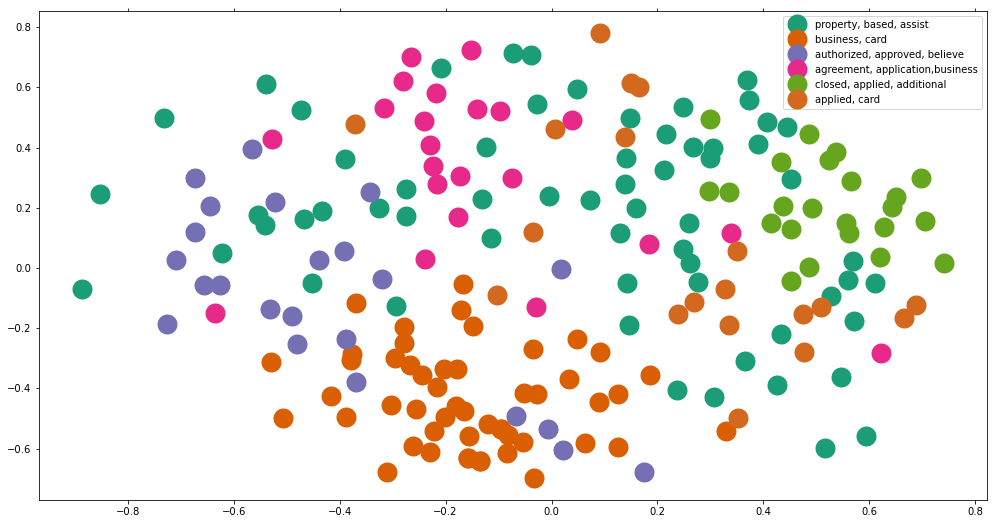

In [34]:
# plot the clusters on a 2D graph

%matplotlib inline

#Create data frame that has the result of the MDS and the cluster 
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 
groups = df.groupby('label')

# Set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=20, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          
        which='both',      
        bottom='off',     
        top='off',         
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',        
        which='both',    
        left='off',     
        top='off',       
        labelleft='off')
    
ax.legend(numpoints=1) 
plt.show()